In [11]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import numpy as np
from sklearn.mixture import BayesianGaussianMixture
from src.utils.spectrum import read_spectrum, norm_spectrum
from src.utils.visualize import clustering_summary, clustering_details

- inputs

In [17]:
# main input file
input_file = './example_data/378.txt'

# default parameters
num_clusters = 4
num_exmaples = 5
have_substrate = False
random_state = 100

- main code / Clustering

In [18]:
x, y = read_spectrum(input_file)

nx, n1, n2 = y.shape

vmin, vmax, ny = norm_spectrum(y, num_bit=0)
spectrums = ny.reshape(nx, -1).T

for i in range(10):
    ny_std = ny.reshape(nx, -1).std(1).reshape(-1)
    std_min, std_max, _ = norm_spectrum(ny_std, num_bit=0)
    mask = ny_std > std_min
    if np.sum(mask) < nx * 0.5: break
    
    ny = ny_std.reshape(-1,1,1) * ny
    _, _, ny = norm_spectrum(ny, num_bit=0)

masked_spectrum = ny.reshape(nx, -1).T[..., mask]

pca = PCA(n_components=20)
pca_vector = pca.fit_transform(masked_spectrum)

# find substrate
mask_sample = np.ones(pca_vector.shape[0], dtype=bool)
if have_substrate:
    gm_sub = BayesianGaussianMixture(n_components=3, random_state=100, covariance_type='spherical')
    l_sub = gm_sub.fit_predict(pca_vector)
    mask_sample = l_sub != np.argmin([masked_spectrum[l_sub == i].std(1).mean() for i in range(3)])
    
# clustering sample area
gm = BayesianGaussianMixture(n_components=num_clusters, random_state=100, covariance_type='spherical')
tsne = TSNE(perplexity=50, init='pca', random_state=100, learning_rate='auto')
tsne_vector = tsne.fit_transform(masked_spectrum[mask_sample])
l1 = gm.fit_predict(pca_vector[mask_sample])

labels = np.ones(n1*n2, dtype=int) * -1
if len(np.unique(l1)) != num_clusters:
    print('Number of clusters changed: {} -> {}'.format(num_clusters, len(np.unique(l1))))
    for i, j in enumerate(np.unique(l1)):
        l1[l1 == j] = i
    num_clusters = len(np.unique(l1))
l2 = l1.copy()
for i, j in enumerate(sorted(np.unique(l1), key=lambda x: masked_spectrum[mask_sample][l1 == x].var(1).mean())):
    l2[l1 == j] = i

labels[mask_sample] = l2

labels = labels.reshape(n1,n2)

- output 

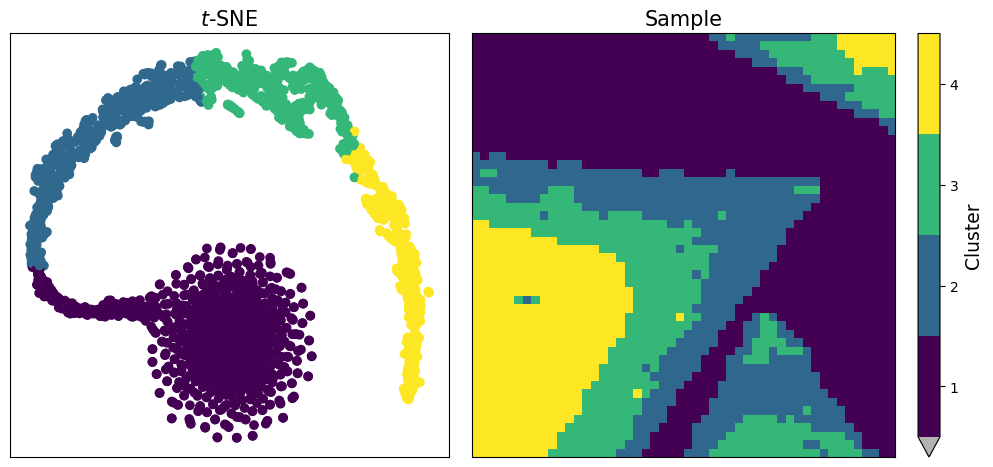

In [19]:
_ = clustering_summary(tsne_vector, labels)

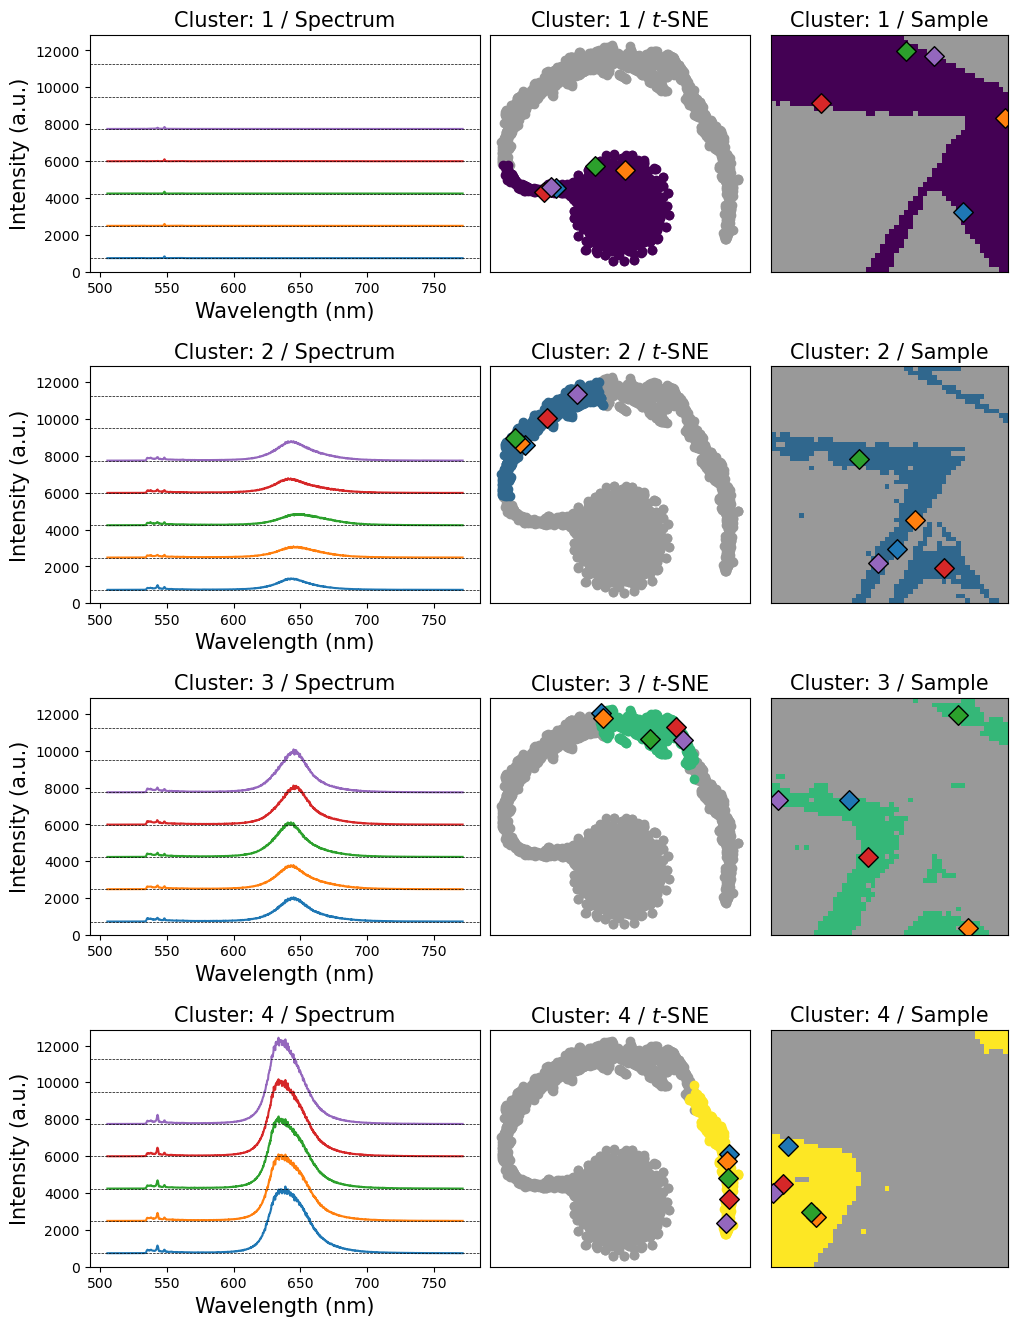

In [20]:
_ = clustering_details(x, y, tsne_vector, labels, num_exmaples)